### Create self supervised dataset

In [1]:
import pandas as pd
import numpy as np
import json
import sagemaker,  io
import re

In [2]:
from datetime import datetime

datefmt = datetime.now().strftime("%Y%m%d%H%M")

In [3]:

s3_external_sources = ["s3://aegovan-data/pubmed-json/pubmed19n0908.json", 
                      "s3://aegovan-data/pubmed-json/pubmed19n0907.json",
                      "s3://aegovan-data/pubmed-json/pubmed19n0906.json",
                      "s3://aegovan-data/pubmed-json/pubmed19n0905.json",
                      "s3://aegovan-data/pubmed-json/pubmed19n0904.json",


                      ]

In [4]:
def upload_df_to_s3_json(df, s3_uri):
#          print("Nothing..")
        json_data = io.StringIO() 
        df.to_json( json_data )
        sagemaker.s3.S3Uploader.upload_string_as_file_body(json_data.getvalue(), s3_uri)



def download_s3_json_to_df(s3_src):
   
    json_str = sagemaker.s3.S3Downloader.read_file( s3_src)
    b = io.StringIO(json_str) 
    df = pd.read_json(b)
    return df



In [5]:
keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]


def filter_abstract_wordlen(df, low=100, high=250):
   

    df = df[df["abstract"].apply(lambda x: low <= len(x.split(" ")) <=high) ].copy()
    
    
    return df


def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       )
    
    
    return df

In [6]:
df_pubmed = pd.concat([download_s3_json_to_df(s).rename(columns = {
    "article_abstract" : "abstract",
    "pubmed_id" : "abstract_id"
}) for s in s3_external_sources])\
    .reset_index(drop=True)[["abstract", "abstract_id"]]

df_pubmed = df_pubmed.pipe(self_label)\
            .pipe(filter_abstract_wordlen, 100, 250)
df_pubmed.head()


,abstract,abstract_id,self_label
0,The anticipation of more than one object dimen...,28552592,False
4,Aconitum karacolicum from northern Kyrgyzstan ...,28552596,False
5,The present study aimed to investigate the vas...,28552597,False
6,A set of PEGylated derivatives of oleanolic an...,28552598,False
7,The Fmr1 knockout (KO) mouse has commonly been...,28552599,False


In [7]:
df_pubmed["self_label"].value_counts()

False    51985
True      3439
Name: self_label, dtype: int64

In [8]:
df_pubmed.head(n=3)

,abstract,abstract_id,self_label
0,The anticipation of more than one object dimen...,28552592,False
4,Aconitum karacolicum from northern Kyrgyzstan ...,28552596,False
5,The present study aimed to investigate the vas...,28552597,False


In [9]:
def create_sample(df):
    b = io.StringIO()
    df.sample(n=10).to_json("self-supervised-sample.json")
    


In [10]:
df_pubmed.self_label.value_counts()

False    51985
True      3439
Name: self_label, dtype: int64

In [11]:
create_sample(df_pubmed)

In [12]:

def randomly_substitute_keywords(x):
    words = [ w for w in x.split(" ") if not any(k.lower() in w.lower() for k in keywords1+keywords2)]
    
    key_i = np.random.choice([0,1])
    if key_i == 0:
        for k in keywords1:
            insensitive = re.compile(re.escape(k), re.IGNORECASE)
            w =  np.random.randint(0,len(words)-1)
            x = insensitive.sub(words[w], x)
    else:
        for k in keywords2:
            insensitive = re.compile(re.escape(k), re.IGNORECASE)
            w =  np.random.randint(0,len(words)-1)
            x = insensitive.sub(words[w], x)
    return x

def randomly_add_keywords(x):
    
    key_i1 = np.random.randint(0,len(keywords1)-1)
    key_i2 = np.random.randint(0,len(keywords2)-1)
    
    key_1 = keywords1[key_i1]
    keys_2 = keywords2[:key_i2] + keywords2[key_i2+1:]
        
    words = x.split(" ")
    l1 =  np.random.randint(0,len(words)-1)
    l2 =  np.random.randint(0,len(words)-1)
    l3 =  np.random.randint(0,len(words)-1)
    
    words.insert(l1, key_1)
    words.insert(l2, keys_2[0])
    words.insert(l3, keys_2[1])

    return " ".join(words)

def randomly_add_words(x):
    
    words = x.split(" ")
    l1 =  np.random.randint(0,len(words)-1)
    l2 =  np.random.randint(0,len(words)-1)
    l3 =  np.random.randint(0,len(words)-1)
    
    w1 = np.random.randint(0,len(words)-1)
    words.insert(l1, words[w1])
    
    w2 = np.random.randint(0,len(words)-1)
    words.insert(l2, words[w2])
    
    w3 = np.random.randint(0,len(words)-1)
    words.insert(l3, words[w3])

    return " ".join(words)

def synthetize_adverserial_abstract( abstract, label):
    if label == True:
        return randomly_substitute_keywords(abstract)
    else:
        return randomly_add_keywords(abstract)



In [13]:
def create_adversarial_positive(df, n_times):  
    assert df.index.nunique() == len(df), "Expect unique index"


    df["is_fake"] = False
    result = []
    for i in range(n_times):
        df_adverserial_pos_to_neg = df.query("self_label == True").copy()
        df_adverserial_pos_to_neg["abstract"] = df_adverserial_pos_to_neg["abstract"].apply(lambda x: synthetize_adverserial_abstract(x, True))
        df_adverserial_pos_to_neg["is_fake"] = True
        result.append(df_adverserial_pos_to_neg)
    
    result_df = pd.concat(result).reset_index(drop=True)
    result_df = result_df.drop_duplicates('abstract')
    result_df = result_df.pipe(self_label)
    
    return result_df

def create_adversarial_negative(df, n_times):  
    assert df.index.nunique() == len(df), "Expect unique index"


    df["is_fake"] = False
    result = []
    for i in range(n_times):
        df_adverserial_neg_to_pos = df.query("self_label == False").copy()
        df_adverserial_neg_to_pos["abstract"] = df_adverserial_neg_to_pos["abstract"].apply(lambda x: synthetize_adverserial_abstract(x, False))
        df_adverserial_neg_to_pos["is_fake"] = True
        result.append(df_adverserial_neg_to_pos)
    
    result_df = pd.concat(result).reset_index(drop=True)
    result_df = result_df.drop_duplicates('abstract')
    result_df = result_df.pipe(self_label)
    


    
    return result_df

In [14]:
      



def create_affable_negatives(df, n_times):  
    assert df.index.nunique() == len(df), "Expect unique index"


    df["is_fake"] = False
    result = []
    for i in range(n_times):
        df_affable_neg = df.query("self_label == False").copy()
        df_affable_neg["abstract"] = df_affable_neg["abstract"].apply(lambda x: randomly_add_words(x))
        df_affable_neg["is_fake"] = True
        result.append(df_affable_neg)
    
    result_df = pd.concat(result).reset_index(drop=True)
    result_df = result_df.drop_duplicates('abstract')
    result_df = result_df.pipe(self_label)
    


    return result_df

def create_affable_positives(df, n_times):  
    assert df.index.nunique() == len(df), "Expect unique index"


    df["is_fake"] = False
    result = []
    for i in range(n_times):
        df_affable_pos = df.query("self_label == True").copy()
        df_affable_pos["abstract"] = df_affable_pos["abstract"].apply(lambda x: randomly_add_words(x))
        df_affable_pos["is_fake"] = True
        result.append(df_affable_pos)
    
    result_df = pd.concat(result).reset_index(drop=True)
    result_df = result_df.drop_duplicates('abstract')
    result_df = result_df.pipe(self_label)

    
    
    return result_df

In [15]:
def get_stats(df, pos_label):
    stats ={}
    
    # Positive samples
    df_positive = df.query(f"self_label == {pos_label}")
    df_positive_unique = df_positive.drop_duplicates('abstract_id')
    stats["UniquePositives"] = len(df_positive_unique)
    stats["AllPositives"] = len(df_positive)
    stats["AffablePositives"] = len(df_positive) - len(df_positive_unique)
    stats["AffablePositiveRate"] = stats["AffablePositives"]/stats["AllPositives"] 


    
    stats["UniquePositiveSampleRate"] = stats["UniquePositives"]/(len(df))
    stats["PositiveSampleRate"] = stats["AllPositives"]/(len(df))
    
    # Negtaive samples
    df_negative = df.query(f"self_label != '{pos_label}'")
    df_negative_unique = df_negative.drop_duplicates('abstract_id')


    stats["UniqueNegatives"] = len(df_negative_unique)
    stats["AllNegatives"] = len(df_negative)
    stats["AffableNegatives"] = len(df_negative) - len(df_negative_unique)
    stats["AffableNegativeRate"] = stats["AffableNegatives"]/stats["AllNegatives"] 



    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries = df[~abstracts_id_with_positive]
    df_negative_non_adverseries_unique =df_negative_non_adverseries.drop_duplicates('abstract_id')
    stats["UniqueNonAdversarialNegatives"] = len(df_negative_non_adverseries_unique)
    stats["AllNonAdversarialNegatives"] = len(df_negative_non_adverseries)

    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries = df[abstracts_id_with_positive].query(f"self_label != {pos_label}")
    df_negative_adverseries_unique = df_negative_adverseries.drop_duplicates('abstract_id')
    stats["UniqueAdversarialNegatives"] = len(df_negative_adverseries_unique)
    stats["AllAdversarialNegatives"] = len(df_negative_adverseries)
    
    # TODO: Check if unique positive is appropriate
    stats["AdversarialRate"] = stats["AllAdversarialNegatives"]/len(df_positive_unique)
    stats["UniqueAdversarialRate"] = stats["UniqueAdversarialNegatives"]/len(df_positive_unique)


    stats["TotalSize"] = len(df)
    stats["UniqueAbstracts"] = df["abstract"].nunique()



    return stats


def mixmatch_training_data_adversarial(df, discriminitory_rate, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    df_positive_all = df.query(f"self_label == {pos_label}")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')
    
    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries_unique = df[abstracts_id_with_positive].query(f"self_label != {pos_label}").drop_duplicates('abstract_id')
    
    df_negative_adverseries_all = df[abstracts_id_with_positive].query(f"self_label != {pos_label}")
    
    
    discriminitory_size = int(len(df_positive_unique)  * discriminitory_rate)
    if discriminitory_size > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, discriminitory_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        df_negative_adverseries_unique = df_negative_adverseries_unique.sample(n=discriminitory_size).copy()
     
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_adverseries_unique]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)


    return final_data



def create_samples_adversarial_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_training_data_adversarial(df, discriminitory_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/adversarial/{}".format( s3_uri_base.rstrip("/"), f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["UniqueAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate"]].plot.line()

In [16]:
import math

def mixmatch_affable_negatives(df, affable_rate, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    df_positive_all = df.query(f"self_label == {pos_label}")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')


    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries_unique = df[abstracts_id_with_positive].query(f"self_label != {pos_label}").drop_duplicates('abstract_id')
    
    df_negative_adverseries_all = df[abstracts_id_with_positive].query(f"self_label != {pos_label}")
    
    
    affable_size = int(len(df_negative_non_adverseries_unique)  * affable_rate)
    df_negative_affable = pd.DataFrame()
    if affable_size > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, affable_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        n_times = math.ceil(affable_size/len(df_negative_non_adverseries_unique))
        
        df_negative_affable = create_affable_negatives(df_negative_non_adverseries_unique, n_times=n_times).sample(n=affable_size)
     
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_affable]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)


    return final_data

def create_affable_negatives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_affable_negatives(df, affable_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/affablenegatives/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffableNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffableNegativeRate"]].plot.line()

In [17]:
def mixmatch_affable_positives(df, affable_rate, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')


 
    
    affable_size = int(len(df_positive_unique)  * affable_rate)
    df_positive_affable = pd.DataFrame()
    df_positive_non_adverseries_unique = df_positive_unique
    if affable_size > 0:
        drop_indices = np.random.choice(df_positive_non_adverseries_unique.index, affable_size, replace=False)
      
        df_positive_non_adverseries_unique = df_positive_non_adverseries_unique.drop(drop_indices).copy()
        
        n_times = math.ceil(affable_size/len(df_positive_non_adverseries_unique))
        
        df_positive_affable = create_affable_positives(df_positive_non_adverseries_unique, n_times=n_times).sample(n=affable_size)
        print(len(df_positive_affable), len(df_positive_non_adverseries_unique))
     
    
    final_data = pd.concat([df_positive_non_adverseries_unique, 
                            df_negative_non_adverseries_unique, 
                            df_positive_affable]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)
    
    return final_data

def create_affable_postives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_affable_positives(df, affable_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/affablepositives/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffablePositives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate"]].plot.line()

In [18]:
def add_affables(df, add_size, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')

    
    df_positive_affable = pd.DataFrame()
    df_negative_affable = pd.DataFrame()
    
    pos_rate = len(df_positive_unique)/(len(df_positive_unique) + len(df_negative_non_adverseries_unique))

    if add_size > 0:
      
        affable_pos_size = int(add_size  * pos_rate)
        affable_neg_size = int(add_size  * (1-pos_rate))

        
        df_positive_affable = create_affable_positives(df_positive_unique,
                                                       n_times=math.ceil(affable_pos_size/len(df_positive_unique)))\
                                                      .sample(n=affable_pos_size)
         
        df_negative_affable = create_affable_negatives(df_negative_non_adverseries_unique,
                                                       n_times=math.ceil(affable_neg_size/len(df_negative_non_adverseries_unique)))\
                                                      .sample(n=affable_neg_size)
    
    final_data = pd.concat([df_positive_unique, 
                            df_positive_affable,
                            df_negative_non_adverseries_unique,
                            df_negative_affable
                            ]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)
    
    return final_data


def create_affable_postivesnegatives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    
    total_sizes = [0,2000,4000,6000,8000]
    for i in total_sizes:

        df_train_data = add_affables(df, add_size=i, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/affablesposnegs/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffablePositives"]+stat["AffableNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        
    
    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate", "AffableNegativeRate"]].plot.line()

In [19]:
def add_adverseries(df, add_size, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')

    
    df_pos_to_neg_adv = pd.DataFrame()
    df_neg_to_pos_adv = pd.DataFrame()
    
    pos_rate = len(df_positive_unique)/(len(df_positive_unique) + len(df_negative_non_adverseries_unique))


    add_size = min(add_size, len(df_positive_unique))

    if add_size > 0:
        adv_pos_size = int(add_size  * pos_rate)
        adv_neg_size = int(add_size  * (1-pos_rate))

        
        df_pos_to_neg_adv = create_adversarial_positive(df_positive_unique,
                                                       n_times=1)\
                                                      .sample(n=adv_neg_size, replace=False)
         
        df_neg_to_pos_adv = create_adversarial_negative(df_negative_non_adverseries_unique,
                                                       n_times=1)\
                                                  .sample(n=adv_pos_size,  replace=False)
    
    final_data = pd.concat([df_positive_unique, 
                            df_neg_to_pos_adv,
                            df_negative_non_adverseries_unique,
                            df_pos_to_neg_adv
                            ]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)
    
    return final_data


def create_adversaries_postivesnegatives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    
    total_sizes = [0,2000]
    for i in total_sizes:



        df_train_data = add_adverseries(df, add_size=i, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/adversariesposnegs/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AllAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        
    
    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate", "AffableNegativeRate"]].plot.line()

In [20]:
def add_for_positives_adverseries(df, df_pubmed_extras, add_size, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')

    
    df_pos_to_neg_adv = pd.DataFrame()
    df_pos_extras = pd.DataFrame()
    
    pos_rate =  len(df_positive_unique)/(len(df_positive_unique) + len(df_negative_non_adverseries_unique))


    add_size = min(add_size, len(df_positive_unique))

    if add_size > 0:
        adv_pos_size = int(add_size  * pos_rate)
        adv_neg_size = int(add_size  * (1-pos_rate))

        
        df_pos_to_neg_adv = create_adversarial_positive(df_positive_unique,
                                                       n_times=1)\
                                                      .sample(n=adv_neg_size, replace=False)
         
        # Select more positive samples to compensate for added adversarial negatives
        df_pos_extras = df_pubmed_extras[~df_pubmed_extras["abstract_id"].isin(df["abstract_id"])]\
                            .query(f"self_label == {pos_label}")\
                            .sample(adv_pos_size)
    
    final_data = pd.concat([df_positive_unique, 
                            df_pos_extras,
                            df_negative_non_adverseries_unique,
                            df_pos_to_neg_adv
                            ]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)
    
    return final_data


def create_vary_adversaries_for_postives_and_upload_to_s3(df, df_pubmed_extras, s3_uri_base, pos_label):
    

    stats = []
    
    total_sizes = [0,2000]
    for i in total_sizes:



        df_train_data = add_for_positives_adverseries(df, df_pubmed_extras, add_size=i, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/adversariespostonegs/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AllAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        
    
    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate", "AffableNegativeRate"]].plot.line()

In [21]:
def add_random_and_positives_adverseries(df, df_pubmed_extras, add_size, pos_label, adv_rate=0.1):
    assert df.index.nunique() == len(df), "Expect unique index"

    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')

    
    df_pos_to_neg_adv = pd.DataFrame()
    df_pos_extras = pd.DataFrame()
    df_neg_extras = pd.DataFrame()
    
    pos_rate =  len(df_positive_unique)/(len(df_positive_unique) + len(df_negative_non_adverseries_unique))

    

    if add_size > 0:
        
        
        pos_add_size = int(add_size  * pos_rate)
        
        adv_pos_to_neg_size = int((len(df_positive_unique) + pos_add_size) * adv_rate)
        
        neg_add_size = int(add_size  * (1-pos_rate)) - adv_pos_to_neg_size

        
        # add random positives
        df_pos_extras = df_pubmed_extras[~df_pubmed_extras["abstract_id"].isin(df["abstract_id"])]\
                            .query(f"self_label == {pos_label}")\
                            .sample(pos_add_size)
        
        # Add adversarial pos_to negatives
        df_pos_to_neg_adv = create_adversarial_positive(pd.concat([df_positive_unique, df_pos_extras]).reset_index(drop=True),
                                                       n_times=1)\
                                                      .sample(n=adv_pos_to_neg_size, replace=False)
                                                      
         
       
        
        # Add random negatives
        df_neg_extras = df_pubmed_extras[~df_pubmed_extras["abstract_id"].isin(df["abstract_id"])]\
                            .query(f"self_label != {pos_label}")\
                            .sample(neg_add_size)
    
    final_data = pd.concat([df_positive_unique, 
                            df_pos_extras,
                            df_negative_non_adverseries_unique,
                            df_pos_to_neg_adv,
                            df_neg_extras
                            ]).reset_index(drop=True)
    
    final_data = final_data.pipe(self_label)
    
    return final_data

def create_random_and_adversaries_for_postives_and_upload_to_s3(df, df_pubmed_extras, s3_uri_base, pos_label):
    

    stats = []
    
    total_sizes = [0,2000, 4000, 6000, 8000]
    for i in total_sizes:

        df_train_data = add_random_and_positives_adverseries(df, df_pubmed_extras, add_size=i, pos_label=pos_label, adv_rate=0.1)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/adversariesrandomandpostonegs/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AllAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        
    
    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[[ "TotalSize", "UniqueAbstracts"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate", "AffableNegativeRate"]].plot.line()

In [22]:
def sample_given_positive_ratio(df, sample_size, pos_ratio):
    
    
    df_pos = df.query("self_label == True")
    df_neg = df.query("self_label == False")
    
    pos_sample_size = int(sample_size * pos_ratio)
    neg_sample_size = int(sample_size * (1-pos_ratio))
    
    df_sample_pos = df_pos.sample(n=pos_sample_size).copy()
    df_sample_neg = df_neg.sample(n=neg_sample_size).copy()

    return pd.concat([df_sample_pos,df_sample_neg]).reset_index(drop=True)


def create_train_val_random(df,  train_size, pos_ratio):
    assert df.index.nunique() == len(df), "Expect unique index"
    
    base_train_size=int(0.8*len(df))
    synthetic_indices = np.random.choice(df.index, base_train_size, replace=False)
        
    # Create train val split
    df_base_train = df[ df.index.isin (synthetic_indices)].copy(deep=True)
    df_base_val = df[~df.index.isin (synthetic_indices)].copy(deep=True)


    df_train = sample_given_positive_ratio(df_base_train, train_size, pos_ratio)
    df_val = sample_given_positive_ratio(df_base_val, int(train_size*0.2), pos_ratio)


  
    
    return df_train, df_val
 

In [23]:
def create_random_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    pos_ratio = 0.25
    
    df_train_random, df_val =  create_train_val_random(df,  10000, pos_ratio)
    
    sample_sizes = [2000,4000,6000,8000, 10000]

    for train_size in sample_sizes:

        df_train_data = sample_given_positive_ratio(df_train_random, train_size, pos_ratio)
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/random/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffablePositives"]+stat["AffableNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffablePositiveRate", "AffableNegativeRate"]].plot.line()
        


In [24]:
df_train_random, df_val = create_train_val_random(df_pubmed,  2000, 0.25)
df_train_with_adversaries = pd.concat([df_train_random, create_adversarial_positive(df_train_random, n_times=1 )]).reset_index(drop=True)
df_train_with_adversaries["self_label"].value_counts()

False    2000
True      500
Name: self_label, dtype: int64

In [25]:
df_val["self_label"].value_counts()

False    300
True     100
Name: self_label, dtype: int64

In [26]:
df_train_random["self_label"].value_counts()

False    1500
True      500
Name: self_label, dtype: int64

In [27]:
df_train_with_adversaries["self_label"].value_counts()

False    2000
True      500
Name: self_label, dtype: int64

In [28]:
df_train_with_adversaries.head()

,abstract,abstract_id,self_label,is_fake
0,Innate immunity is the first line of defense a...,28573616,True,False
1,Nannochloropsis spp. are algae with high poten...,28499880,True,False
2,Non-small cell lung cancer (NSCLC) remains the...,28487464,True,False
3,Maintaining the integrity of genetic informati...,28477125,True,False
4,"Proline aminopeptidase (PAP, EC 3.4.11.5) is t...",28482331,True,False


## Fixed train size

In [29]:
upload_df_to_s3_json(df_val, f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}/val.json")

## Adverserial positives

s3://aegovan-data/self-supervised-fake-fixed-size/202212302239/adversarial/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-fixed-size/202212302239/adversarial/train_2000_500_50.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1450, 'AllNonAdversari

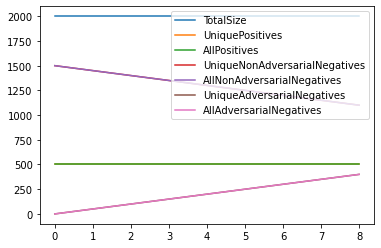

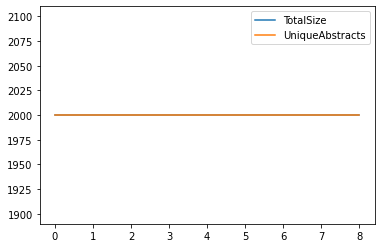

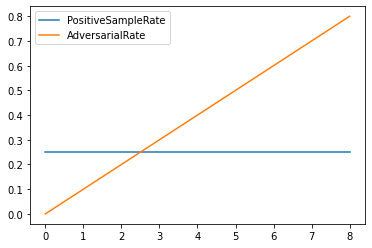

In [30]:
create_samples_adversarial_and_upload_to_s3(df_train_with_adversaries, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}")



## Affables

### Affable negatives

s3://aegovan-data/self-supervised-fake-fixed-size/202212302239/affablenegatives/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-fixed-size/202212302239/affablenegatives/train_2000_500_150.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1350, 'AllNegatives': 1500, 'AffableNegatives': 150, 'AffableNegativeRate': 0.1, 'UniqueNonAdversarialNegatives': 1350, 'Al

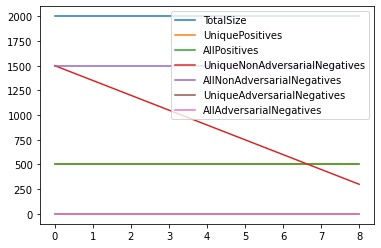

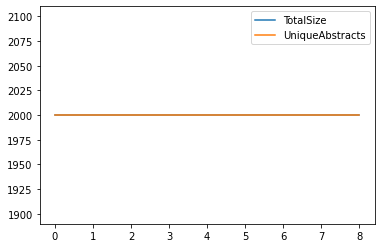

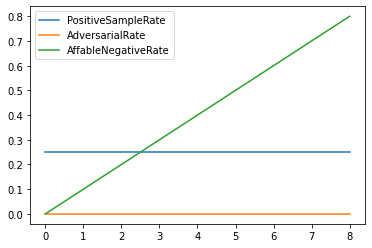

In [31]:
create_affable_negatives_and_upload_to_s3(df_train_random, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}")

### Affable positives

s3://aegovan-data/self-supervised-fake-fixed-size/202212302239/affablepositives/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
50 450
s3://aegovan-data/self-supervised-fake-fixed-size/202212302239/affablepositives/train_2000_500_50.json {'UniquePositives': 450, 'AllPositives': 500, 'AffablePositives': 50, 'AffablePositiveRate': 0.1, 'UniquePositiveSampleRate': 0.225, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 150

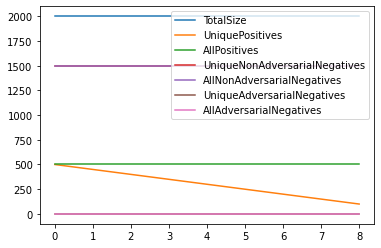

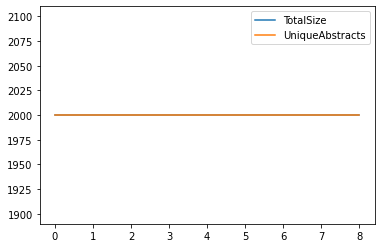

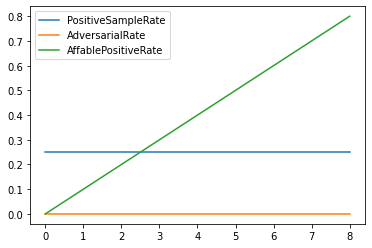

In [32]:
create_affable_postives_and_upload_to_s3(df_train_random, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}")

## Increase Train size

In [33]:
upload_df_to_s3_json(df_val, f"s3://aegovan-data/self-supervised-fake-vary-size/{datefmt}/val.json")

### Affables increase size

s3://aegovan-data/self-supervised-fake-vary-size/202212302239/affablesposnegs/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-vary-size/202212302239/affablesposnegs/train_4000_1000_2000.json {'UniquePositives': 500, 'AllPositives': 1000, 'AffablePositives': 500, 'AffablePositiveRate': 0.5, 'UniquePositiveSampleRate': 0.125, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 3000, 'AffableNegatives': 1500, 'AffableNegativeRate': 0.5, 'UniqueNonAdversarialNegatives': 1500, 

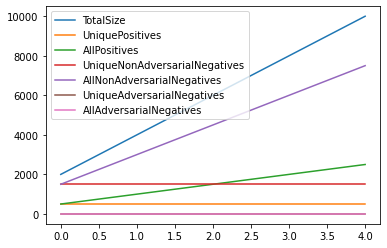

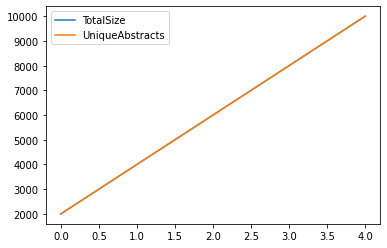

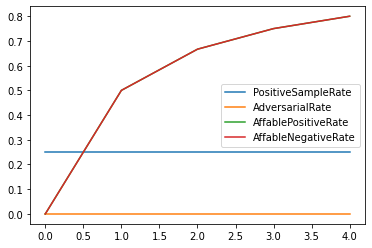

In [34]:
create_affable_postivesnegatives_and_upload_to_s3(df_train_random, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-vary-size/{datefmt}")



### Random

s3://aegovan-data/self-supervised-fake-vary-size/202212302239/random/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-vary-size/202212302239/random/train_4000_1000_0.json {'UniquePositives': 1000, 'AllPositives': 1000, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 3000, 'AllNegatives': 3000, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 3000, 'AllNonAdversarialNegative

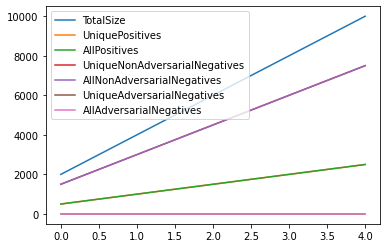

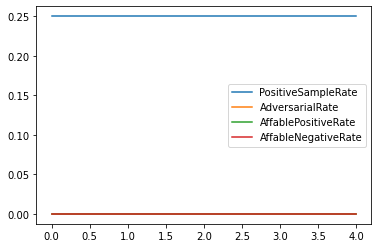

In [35]:
create_random_and_upload_to_s3(df_pubmed, f"s3://aegovan-data/self-supervised-fake-vary-size/{datefmt}",pos_label=True )

### Adversarials 

s3://aegovan-data/self-supervised-fake-vary-size/202212302239/adversariesposnegs/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-vary-size/202212302239/adversariesposnegs/train_2500_625_500.json {'UniquePositives': 625, 'AllPositives': 625, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1875, 'AllNegatives': 1875, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1375, 'Al

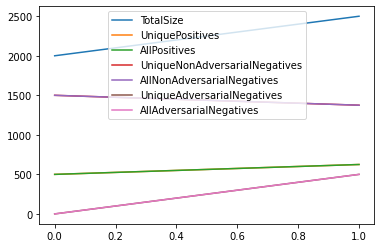

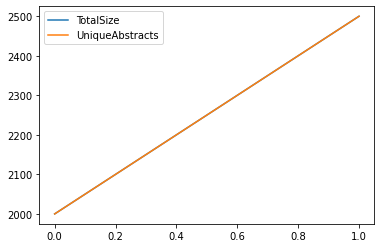

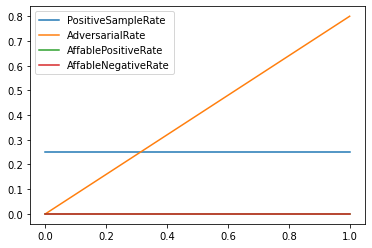

In [36]:
create_adversaries_postivesnegatives_and_upload_to_s3(df_train_random, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-vary-size/{datefmt}")

### Adversarial Positives

s3://aegovan-data/self-supervised-fake-vary-size/202212302239/adversariespostonegs/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-vary-size/202212302239/adversariespostonegs/train_2500_625_375.json {'UniquePositives': 625, 'AllPositives': 625, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1875, 'AllNegatives': 1875, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500,

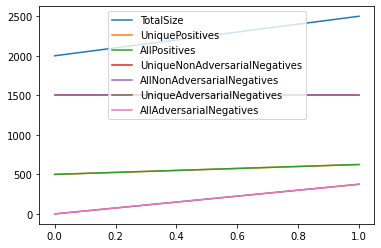

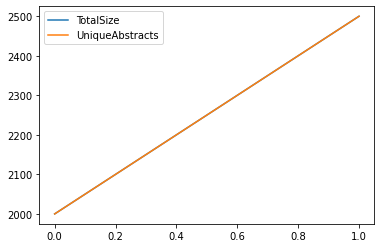

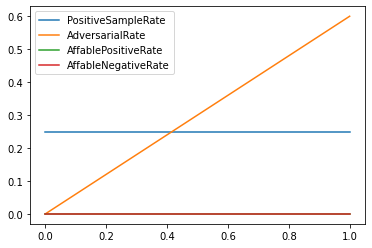

In [37]:
create_vary_adversaries_for_postives_and_upload_to_s3(df_train_random, df_pubmed, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-vary-size/{datefmt}")

s3://aegovan-data/self-supervised-fake-vary-size/202212302239/adversariesrandomandpostonegs/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-vary-size/202212302239/adversariesrandomandpostonegs/train_4000_1000_100.json {'UniquePositives': 1000, 'AllPositives': 1000, 'AffablePositives': 0, 'AffablePositiveRate': 0.0, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 3000, 'AllNegatives': 3000, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversa

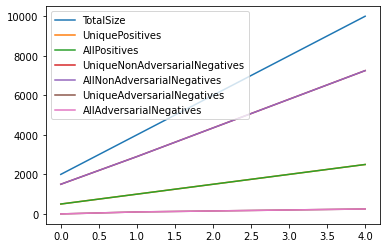

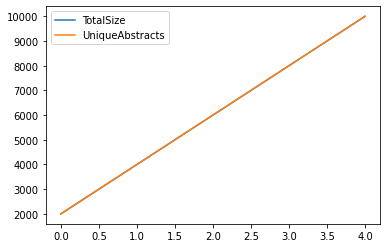

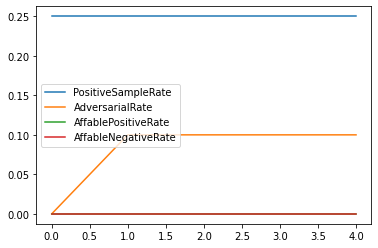

In [38]:
create_random_and_adversaries_for_postives_and_upload_to_s3(df_train_random, df_pubmed, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-vary-size/{datefmt}"

)